<a href="https://colab.research.google.com/github/aderdouri/ql_web_app/blob/master/ql_notebooks/dangerous_day_counters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dangerous day-count conventions

(Based on a question by Min Gao on the QuantLib mailing list. Thanks!)

In [ ]:
!pip install QuantLib-Python

In [ ]:
# URL of the Python file
url = 'https://raw.githubusercontent.com/aderdouri/ql_web_app/master/ql_notebooks/utils.py'

# Download the file
urllib.request.urlretrieve(url, 'utils.py')

# Import the module
spec = importlib.util.spec_from_file_location("utils", "utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["utils"] = utils
spec.loader.exec_module(utils)

In [ ]:
import QuantLib as ql

In [ ]:
today = ql.Date(22,1,2018)
ql.Settings.instance().evaluationDate = today

In [ ]:
%matplotlib inline
import utils

#### The problem

Talking about term structures in [_Implementing QuantLib_](https://leanpub.com/implementingquantlib), I suggest to use simple day-count conventions such as Actual/360 or Actual/365 to initialize curves. That's because the convention is used internally to convert dates into times, and we want the conversion to be as regular as possible.  For instance, we'd like distances between dates to be additive: given three dates $d_1$, $d_2$ and $d_3$, we would expect that $T(d_1,d_2) + T(d_2,d_3) = T(d_1,d_3)$, where $T$ denotes the time between dates.

Unfortunately, that's not always the case for some day counters. The property holds for most dates...

In [ ]:
dc = ql.Thirty360(ql.Thirty360.USA)

In [ ]:
d1 = ql.Date(1, ql.January, 2018)
d2 = ql.Date(15, ql.January, 2018)
d3 = ql.Date(31, ql.January, 2018)

In [ ]:
print(dc.yearFraction(d1,d2) + dc.yearFraction(d2,d3))
print(dc.yearFraction(d1,d3))

0.08333333333333334
0.08333333333333333


...but doesn't for some.

In [ ]:
d1 = ql.Date(1, ql.January, 2018)
d2 = ql.Date(30, ql.January, 2018)
d3 = ql.Date(31, ql.January, 2018)

In [ ]:
print(dc.yearFraction(d1,d2) + dc.yearFraction(d2,d3))
print(dc.yearFraction(d1,d3))

0.08055555555555556
0.08333333333333333


That's because some day-count conventions were designed to calculate the duration of a coupon, not the distance between any two given dates.  They have particular formulas and exceptions that make coupons more regular; but those exceptions also cause some pairs of dates to have strange properties.  For instance, there might be no distance at all between some particular distinct dates:

In [ ]:
d1 = ql.Date(30, ql.January, 2018)
d2 = ql.Date(31, ql.January, 2018)

print(dc.yearFraction(d1,d2))

0.0


The 30/360 convention is not the worst offender, either.  Min Gao's question came from using for the term structure the same convention used for the bond being priced, that is, ISMA actual/actual.  This day counter is supposed to be given a reference period, as well as the two dates whose distance one needs to measure; failing to do so will result in the wrong results...

In [ ]:
d1 = ql.Date(1, ql.January, 2018)
d2 = ql.Date(15, ql.January, 2018)

reference_period = (ql.Date(1, ql.January, 2018), ql.Date(1, ql.July, 2018))

In [ ]:
dc = ql.ActualActual(ql.ActualActual.ISMA)

print(dc.yearFraction(d1, d2, *reference_period))
print(dc.yearFraction(d1, d2))

0.03867403314917127
0.038356164383561646


...and sometimes, in spectacularly wrong results.  Here is what happens if we plot the year fraction since January 1st, 2018 as a function of the date over that same year.

In [ ]:
d1 = ql.Date(1, ql.January, 2018)
dates = [ (d1 + i) for i in range(366) ]
times = [ dc.yearFraction(d1, d) for d in dates ]

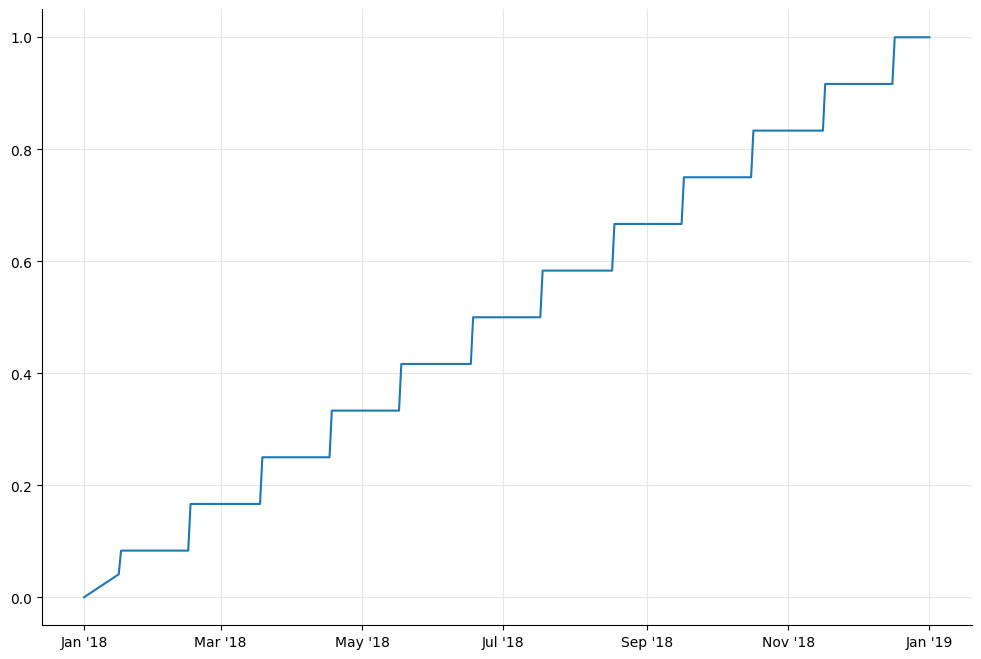

In [ ]:
fig, ax = utils.plot()
ax.xaxis.set_major_formatter(utils.date_formatter())
ax.plot_date([ utils.to_datetime(d) for d in dates ], times,'-');

Of course, that's no way to convert dates into times.  Using this day-count convention inside a coupon is ok, of course.  Using it inside a term structure, which doesn't have any concept of a reference period, leads to very strange behaviors.

In [ ]:
curve = ql.FlatForward(today, 0.01, ql.ActualActual(ql.ActualActual.ISMA))

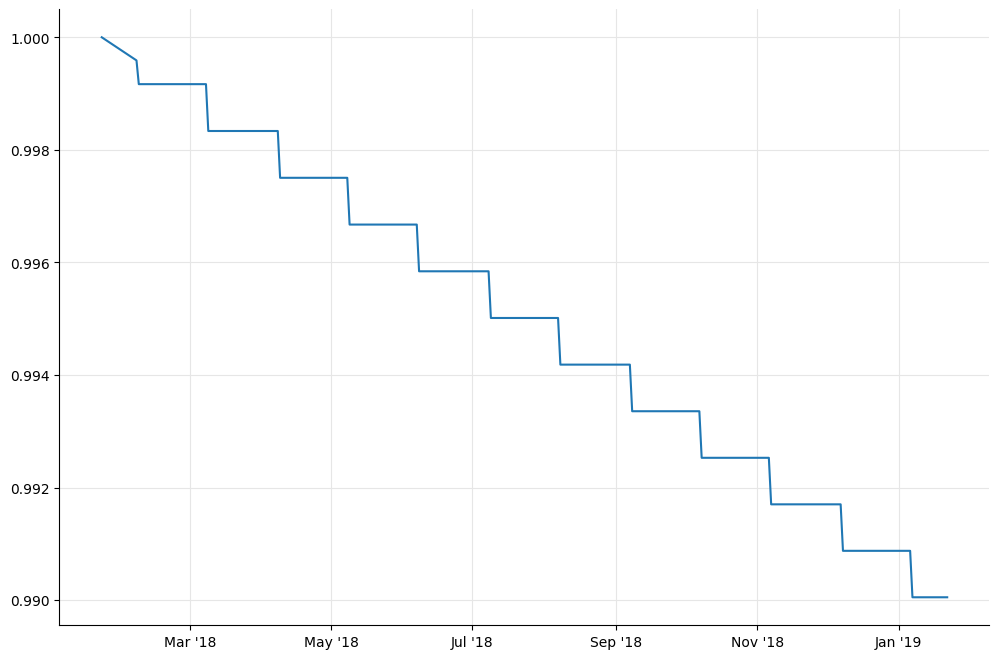

In [ ]:
dates = [ (today + i) for i in range(366) ]
discounts = [ curve.discount(d) for d in dates ]
fig, ax = utils.plot()
ax.xaxis.set_major_formatter(utils.date_formatter())
ax.plot_date([ utils.to_datetime(d) for d in dates ], discounts,'-');

#### Any solutions?

Not really, at this time.  Work is underway to store a schedule inside an ISMA actual/actual day counter and use it to retrieve the correct reference period, but that's not fully working yet. In the meantime, what I can suggest is to use the specified day-count conventions for coupons; but, unless something prevents it, use a simple day-count convention such as actual/360 or actual/365 for term structures.